In [103]:
import sqlite3
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

The visualisations are based on the provided date base and can be filtered by a date.
The date is retrieved and filtered based on SQL queries. Processed using the Python program language.
Visualisations are created using the matplotlib library.

Statistic date in format YYYY-MM-DD
leave string empty as '' to get global statistic

In [104]:
date = '2014-06-08'

In [105]:
db_filename = 'dinofunworld.db'
connection = sqlite3.connect(db_filename)
cursor = connection.cursor()


def execute_query(query: str) -> str:
    formatted_date = f"'{date}%'"
    formatted_query = query.format(formatted_date)

    return cursor.execute(formatted_query).fetchall()

**Question 1:** What is the most popular attraction to visit in the park?
The visualization was created based on the data from the Attractions and Checkin tables.
The Y-axis is responsible for the type of attraction with the name of the most popular one in brackets.
The X-axis represents the number of visits in increments of 2k.

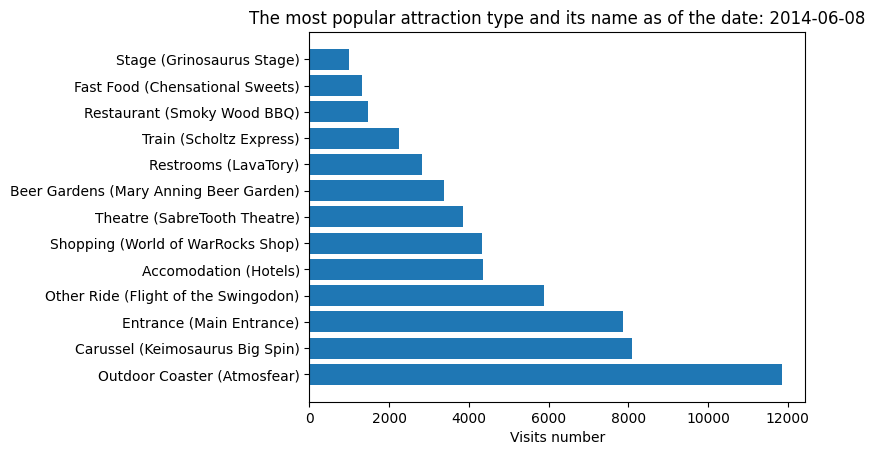

In [106]:
most_popular_attraction_query = """
SELECT DISTINCT Attraction.AttractionID, Attraction.Name, Attraction.type, COUNT(Checkin.attraction) AS attraction_count
FROM Attraction
LEFT JOIN Checkin ON Attraction.AttractionID = Checkin.attraction
WHERE Checkin.timestamp LIKE {}
GROUP BY Attraction.AttractionID
ORDER BY attraction_count DESC;
"""

data = execute_query(most_popular_attraction_query)
data = [(item[0], item[1], item[2].replace('\n', ''), item[3]) if '\n' in item[2] else item for item in data]

result = []
for category in set(x[2] for x in data):
    max_value = max((x[3], x[1]) for x in data if x[2] == category)
    result.append((category, max_value[1], max_value[0]))

attraction_data = sorted(result, key=lambda x: -x[2])

attraction_type = [f"{x[0]} ({x[1]})" for x in attraction_data]
visits_number = [x[2] for x in attraction_data]

plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(visits_number))

ax.barh(y_pos, visits_number, align='center')
ax.set_yticks(y_pos, labels=attraction_type)
ax.set_xlabel('Visits number')
ax.set_title(f'The most popular attraction type and its name as of the date: {date}')

plt.show()

**Question 2:** What ride (note that not all attractions are rides) has the longest visit time?
The visualization is based on data from the Attractions and Checkin tables.
The Y-axis is responsible for the Name of the attraction.
The X-axis represents longest visit time for attraction in minutes.

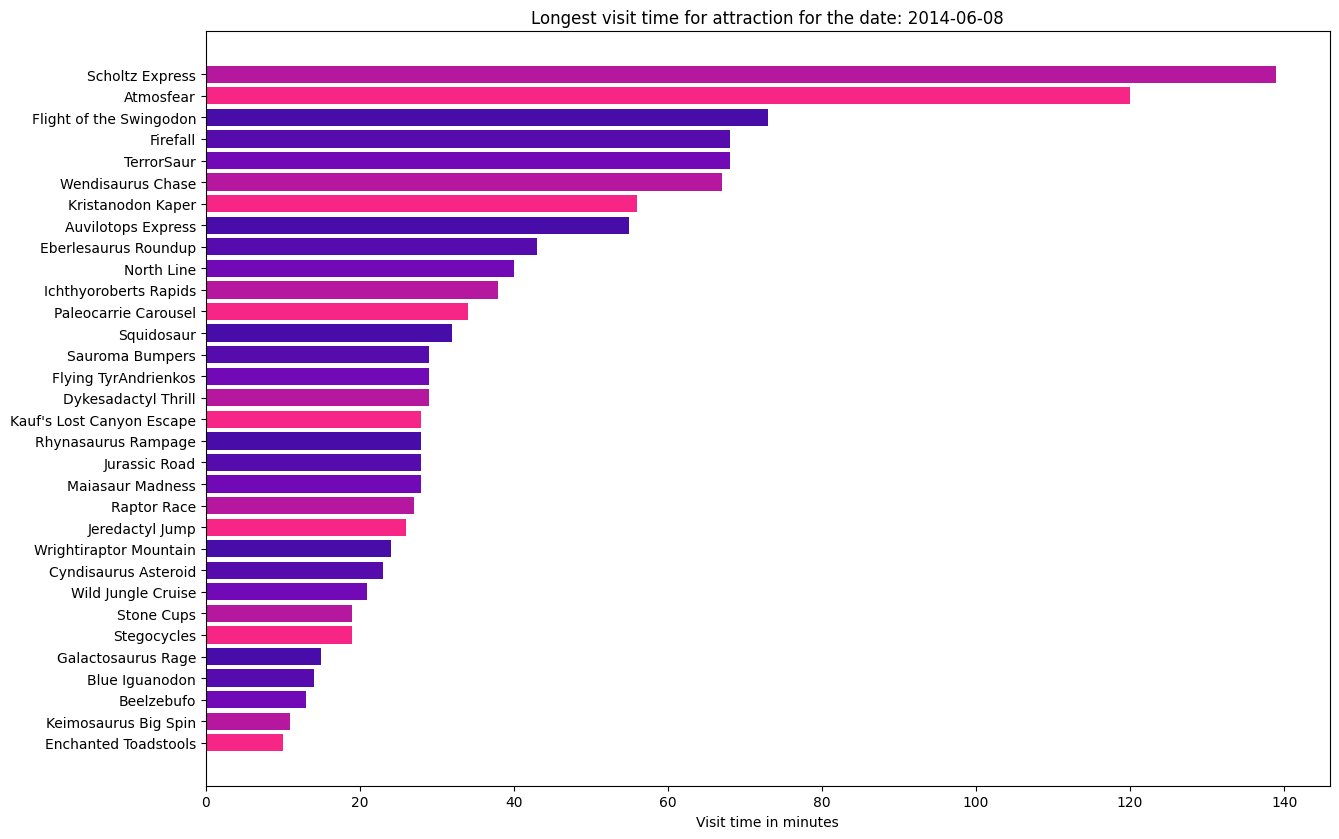

In [107]:
ride_data_query = """
SELECT AttractionID, Attraction.Name, Attraction.type, MAX(Checkin.duration) AS total_duration
FROM Checkin
JOIN Attraction
ON Checkin.attraction = Attraction.AttractionID
WHERE Category LIKE '%Ride%' AND Checkin.duration NOT LIKE '%@SD' AND Checkin.timestamp LIKE {}
GROUP BY AttractionID
ORDER BY total_duration DESC;
"""

data = execute_query(ride_data_query)
attraction_name = [x[1] for x in data]
ride_duration = [x[3] for x in data]
time_strings = [int(t.split(':')[0]) * 60 + int(t.split(':')[1]) for t in ride_duration]

plt.rcParams["figure.figsize"] = [13.50, 8.50]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()
y_pos = np.arange(len(time_strings))

ax.barh(y_pos, time_strings[::-1], align='center', color=['#f72585', '#b5179e', '#7209b7', '#560bad', '#480ca8'])
ax.set_yticks(y_pos, labels=attraction_name[::-1])
ax.set_xlabel('Visit time in minutes')
ax.set_title(f'Longest visit time for attraction for the date: {date}')

plt.show()

**Question 3:** Which Fast Food offering has the fewest visitors?
The visualization is based on data from the Attractions and Checkin tables.
The pie chart is divided by restaurant names. Each sector is responsible for the share of visits to the restaurant in the total number of visits.
The separated sector shows the restaurant with the lowest number of visitors.

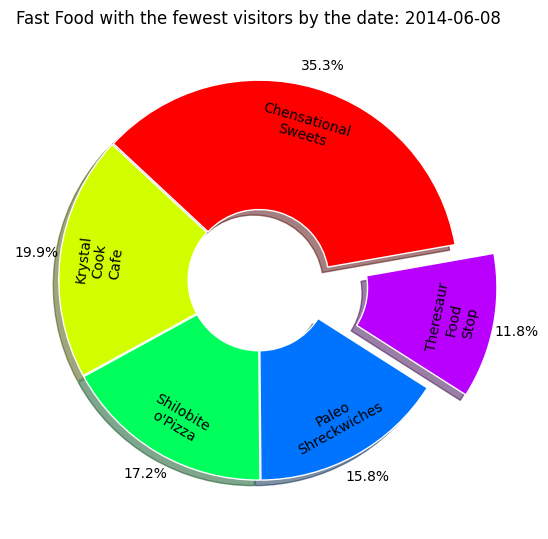

In [108]:
fast_food_data_query = """
SELECT AttractionID, Attraction.Name, COUNT(Checkin.attraction) as total_visists
FROM Checkin
JOIN Attraction
ON Checkin.attraction = Attraction.AttractionID
WHERE Attraction.type LIKE '%Fast Food%' AND Checkin.timestamp LIKE {}
GROUP BY AttractionID
ORDER BY total_visists DESC;
"""

data = execute_query(fast_food_data_query)

fast_food_dicts = {
    'Fast Food names': [x[1].replace(' ', '\n') for x in data],
    'Visits number': [x[2] for x in data]
}

df = pd.DataFrame(fast_food_dicts)

plt.rcParams["figure.figsize"] = [10.50, 5.50]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()

size = 0.65
cmap = plt.get_cmap('hsv', 2056)
outer_colors = np.arange(5) * 411
inner_colors = [x + 35 for x in outer_colors]

explode_values = np.full_like([float(x) for x in fast_food_dicts['Visits number']], 0.005)
min_idx = np.argmin(fast_food_dicts['Visits number'])
explode_values[min_idx] = 0.2

common_params = dict(
    shadow=True,
    startangle=10,
    rotatelabels=True,
    labeldistance=0.8,
    explode=explode_values,
    wedgeprops=dict(width=size, edgecolor='w'))

pie1 = ax.pie(df['Visits number'].values.flatten(),
              radius=1,
              colors=cmap(outer_colors),
              autopct='%1.1f%%',
              pctdistance=1.12,
              labels=df['Fast Food names'],
              **common_params)

pie_arr = [pie1[1]]

for pie in pie_arr:
    plt.setp(pie, rotation_mode="anchor", ha="center", va="center")

    for tx in pie:
        rot = tx.get_rotation()
        tx.set_rotation(rot + 90 + (1 - rot // 90) * 180)

ax.set(aspect="equal", title=f'Fast Food with the fewest visitors by the date: {date}')
plt.show()

**Question 4:** Compute the Skyline of number of visits and visit time for the park's ride and report the rides that appear in the Skyline.
For this computation, we find the set of Pareto optimal points, which are the points where no other point dominates it in both dimensions.

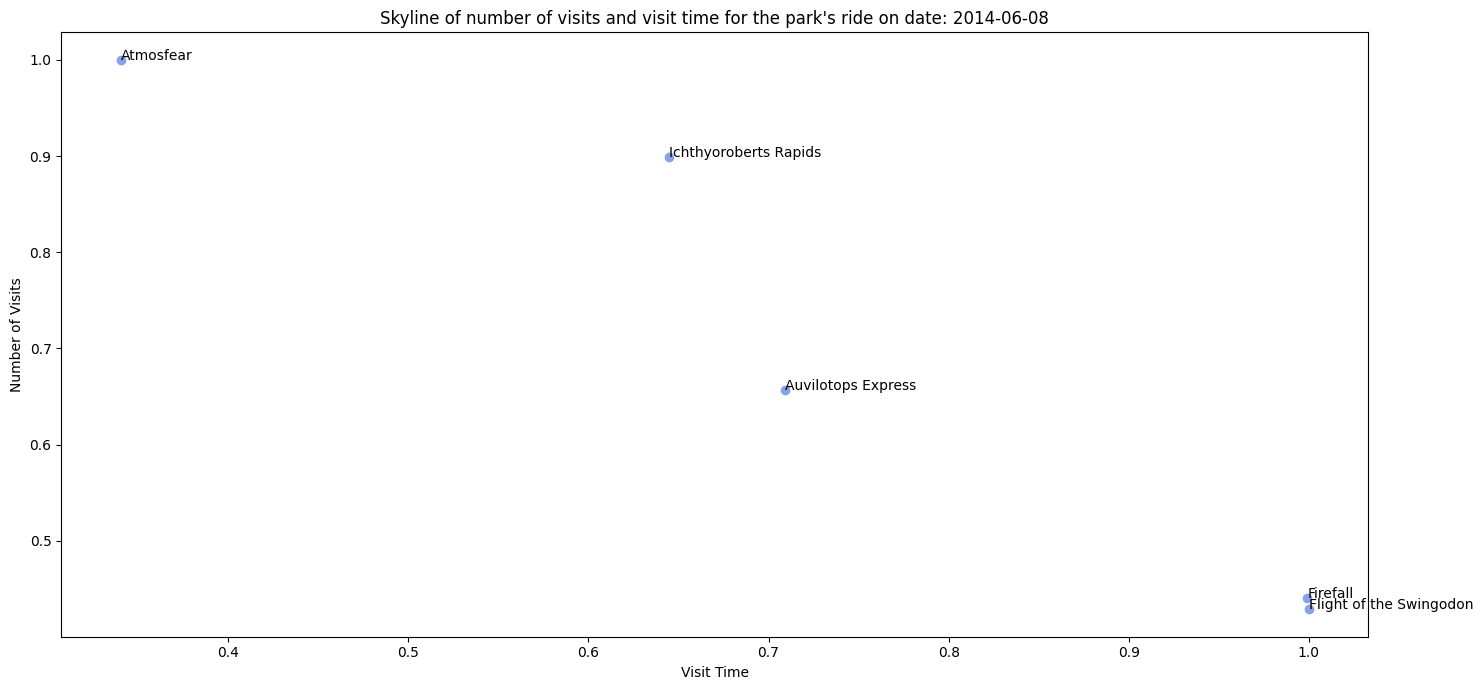

In [109]:
skyline_query = """
SELECT AttractionID, Attraction.Name, Attraction.type, COUNT(Checkin.attraction) AS attraction_count,
 SUM(
    strftime('%H', '1970-01-01 0' || Checkin.duration)*3600 +
    strftime('%M', '1970-01-01 0' || Checkin.duration)*60 +
    strftime('%S', '1970-01-01 0' || Checkin.duration)
    ) AS average_time
FROM Checkin
JOIN Attraction
ON Checkin.attraction = Attraction.AttractionID
WHERE Category LIKE '%Ride%' AND Checkin.duration NOT LIKE '%@SD' AND Checkin.duration NOT LIKE '%null' AND Checkin.timestamp LIKE {}
GROUP BY AttractionID
ORDER BY attraction_count DESC;
"""
data = execute_query(skyline_query)

attraction_name = [x[1] for x in data]
ride_duration = [int(t[4] / 3600) for t in data]
visits_number = [x[3] for x in data]

skyline_data = list(zip(attraction_name, ride_duration, visits_number))
data = np.array(skyline_data)

visit_time = data[:, 1].astype(float)
num_visits = data[:, 2].astype(float)

visit_time_norm = (visit_time - visit_time.min()) / (visit_time.max() - visit_time.min())
num_visits_norm = (num_visits - num_visits.min()) / (num_visits.max() - num_visits.min())

data_norm = np.column_stack((visit_time_norm, num_visits_norm))

pareto_optimal = set()
attraction_names = []

for i, (x, y) in enumerate(data_norm):
    is_pareto_optimal = True
    for j, (x2, y2) in enumerate(data_norm):
        if x2 > x and y2 > y:
            is_pareto_optimal = False
            break
    if is_pareto_optimal:
        pareto_optimal.add(i)
        attraction_names.append(data[i][0])

fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(visit_time_norm[list(pareto_optimal)], num_visits_norm[list(pareto_optimal)], color='#87A1EA')

ax.set_xlabel("Visit Time")
ax.set_ylabel("Number of Visits")
ax.set_title(f"Skyline of number of visits and visit time for the park's ride on date: {date}")

for i, txt in enumerate(attraction_names):
    ax.annotate(txt, (visit_time_norm[list(pareto_optimal)][i], num_visits_norm[list(pareto_optimal)][i]))

plt.show()
